In [1]:
import sys
sys.path.append("..")

In [2]:
import os

# prevent JAX from preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# data loading
import pandas as pd
import numpy as np

# plotting
#import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# pyro
import numpyro
import numpyro.distributions as dist
from numpyro.infer import Predictive
from numpyro.handlers import condition, trace
from numpyro.contrib.control_flow import scan, cond

numpyro.set_host_device_count(4)

# jax
import jax
import jax.numpy as jnp
import jax.random as random

if any([d.platform == "gpu" for d in jax.devices()]):
    numpyro.set_platform("gpu")

from jax.lib import xla_bridge
print(f"current XLA device: {xla_bridge.get_backend().platform}")

import weathergen as wx
import wxsbi

/opt/miniconda3/envs/wxsbi/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/3m/5yx1mwc969n3ddb__zkqyzdr0000gn/T/ipykernel_37689/3221953179.py:33: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated and will be removed in JAX v0.8.0; use jax.extend.backend.get_backend.
  print(f"current XLA device: {xla_bridge.get_backend().platform}")


current XLA device: cpu


In [3]:
# enable autoreload of source files
%load_ext autoreload
%autoreload 2

# Data

In [ ]:
import weathergen.data

station_ids = [2171, 2738, 3404, 19582, 19087, 3666, 5029, 5419, 5434, 151] 


basin_data_list = []
basin_data_list_ids = []
skipped_stations = []

for station_id in station_ids:
    print(f"\n🔹 Processing station {station_id}...")

    # Variable name mapping
    name_map = weathergen.data.data_var_name_map(
        prec="pr", Tair_mean="tavg", Tair_min="tmin", Tair_max="tmax", time="date"
    )

    # Load dataset
    basin_data_all = wx.data.load_time_series_csv(
        f"../../new_stations/{station_id}.csv", name_map
    ).dropna()

    # Select training period
    basin_data_train = basin_data_all["1950":"1999"]

    # Remove invalid rows
    invalid_mask = (basin_data_train["Tair_min"] >= basin_data_train["Tair_mean"]) | (
        basin_data_train["Tair_max"] <= basin_data_train["Tair_mean"]
    )
    n_invalid = invalid_mask.sum()

    if n_invalid > 0:
        print(f"⚠️ Warning: Removing {n_invalid} invalid rows for station {station_id} "
              f"(Tmin ≥ Tavg or Tmax ≤ Tavg)")
        basin_data_train = basin_data_train.loc[~invalid_mask]

    # Skip station if no data left
    if basin_data_train.shape[0] == 0:
        print(f"⚠️ Warning: Station {station_id} has no valid data after filtering. Skipping.")
        skipped_stations.append(station_id)
        continue

    # Assertions
    assert np.all(basin_data_train["Tair_min"] < basin_data_train["Tair_mean"]), f"Tmin ≥ Tavg for station {station_id}"
    assert np.all(basin_data_train["Tair_min"] < basin_data_train["Tair_max"]), f"Tmin ≥ Tmax for station {station_id}"
    assert np.all(basin_data_train["Tair_mean"] < basin_data_train["Tair_max"]), f"Tavg ≥ Tmax for station {station_id}"
    assert np.all(basin_data_train["prec"] >= 0), f"Negative precipitation for station {station_id}"

    print(f"✅ Station {station_id}: {basin_data_train.shape[0]} valid rows remain.")
    basin_data_list.append(basin_data_train)
    basin_data_list_ids.append(station_id)

print("\n✅ All stations processed successfully.")
if skipped_stations:
    print("⚠️ Skipped stations (no valid data after filtering):", skipped_stations)


🔹 Processing station 5029...
✅ Station 5029: 8980 valid rows remain.

✅ All stations processed successfully.


# Run

In [5]:
from weathergen.wgen.wgen_gamlss import *
from numpyro.infer.autoguide import AutoMultivariateNormal

import torch
torch.manual_seed(1234)

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)


🔹 Fitting GAMLSS model for station 5029...


100%|██████████| 50000/50000 [02:15<00:00, 367.99it/s, init loss: 2958249.0000, avg. loss [47501-50000]: 25707.4785]
INFO:wxsbi.wxsbi:Running 2000 simulations for calibration posterior mean
100%|██████████| 4/4 [00:39<00:00,  9.79s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for full calibration posterior
100%|██████████| 4/4 [00:38<00:00,  9.61s/it]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI prior
100%|██████████| 4/4 [00:38<00:00,  9.68s/it]
INFO:wxsbi.wxsbi:Running SBI...
INFO:wxsbi.wxsbi:Starting round 1/5
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:20<00:00, 10.14s/it]
INFO:wxsbi.wxsbi:Training estimator


 Training neural network. Epochs trained: 52

INFO:wxsbi.wxsbi:Starting round 2/5


 Neural network successfully converged after 53 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1465.06it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:19<00:00,  9.99s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 84

INFO:wxsbi.wxsbi:Starting round 3/5


 Neural network successfully converged after 85 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1673.94it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:19<00:00,  9.93s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 32

INFO:wxsbi.wxsbi:Starting round 4/5


 Neural network successfully converged after 33 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1681.43it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:19<00:00,  9.97s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Training neural network. Epochs trained: 20

INFO:wxsbi.wxsbi:Starting round 5/5


 Neural network successfully converged after 21 epochs.

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1680.79it/s]
INFO:wxsbi.wxsbi:Running 1000 simulations...
100%|██████████| 2/2 [00:19<00:00,  9.95s/it]
INFO:wxsbi.wxsbi:Training estimator


Using SNPE-C with atomic loss
 Neural network successfully converged after 42 epochs.

Drawing 2000 posterior samples: 100%|██████████| 2000/2000 [00:01<00:00, 1903.54it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior
100%|██████████| 4/4 [00:40<00:00, 10.24s/it]
INFO:wxsbi.wxsbi:Finding MAP estimate
Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 1614.20it/s]
INFO:wxsbi.wxsbi:Running 2000 simulations for SBI posterior MAP estimate
100%|██████████| 4/4 [00:38<00:00,  9.65s/it]


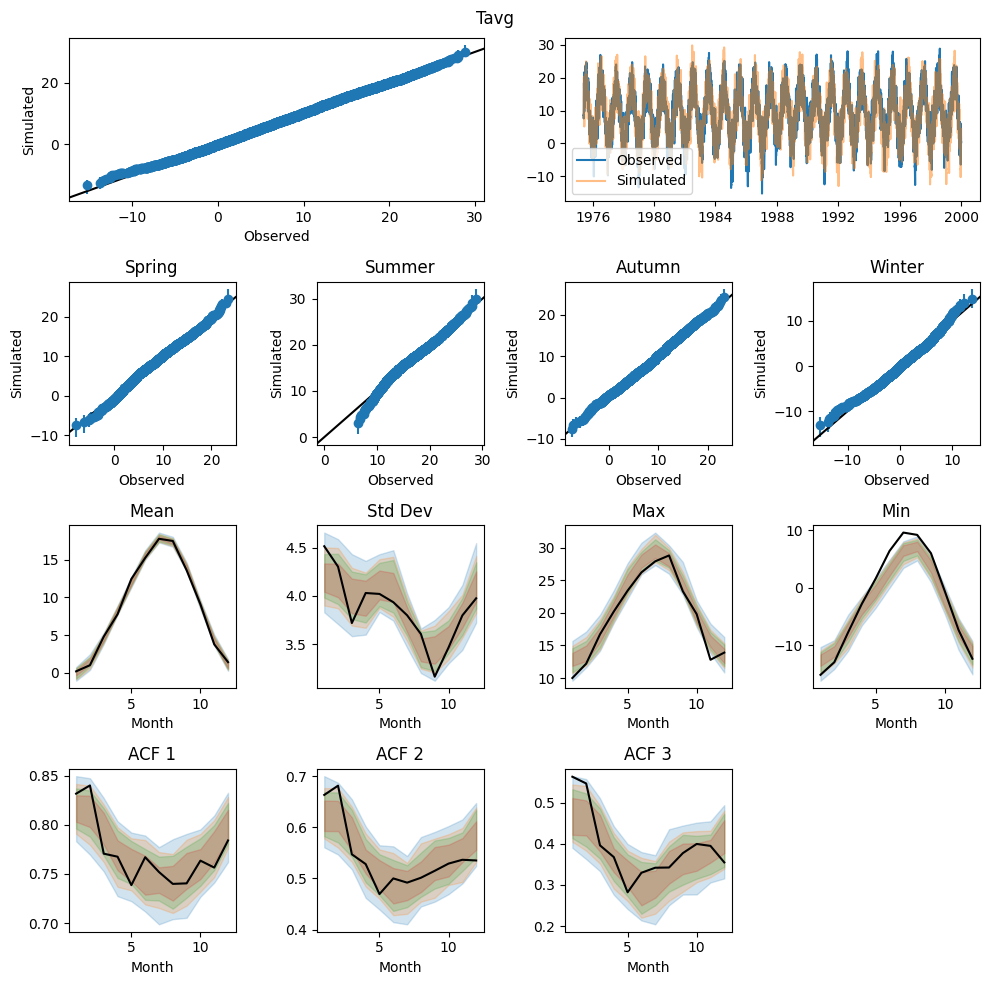

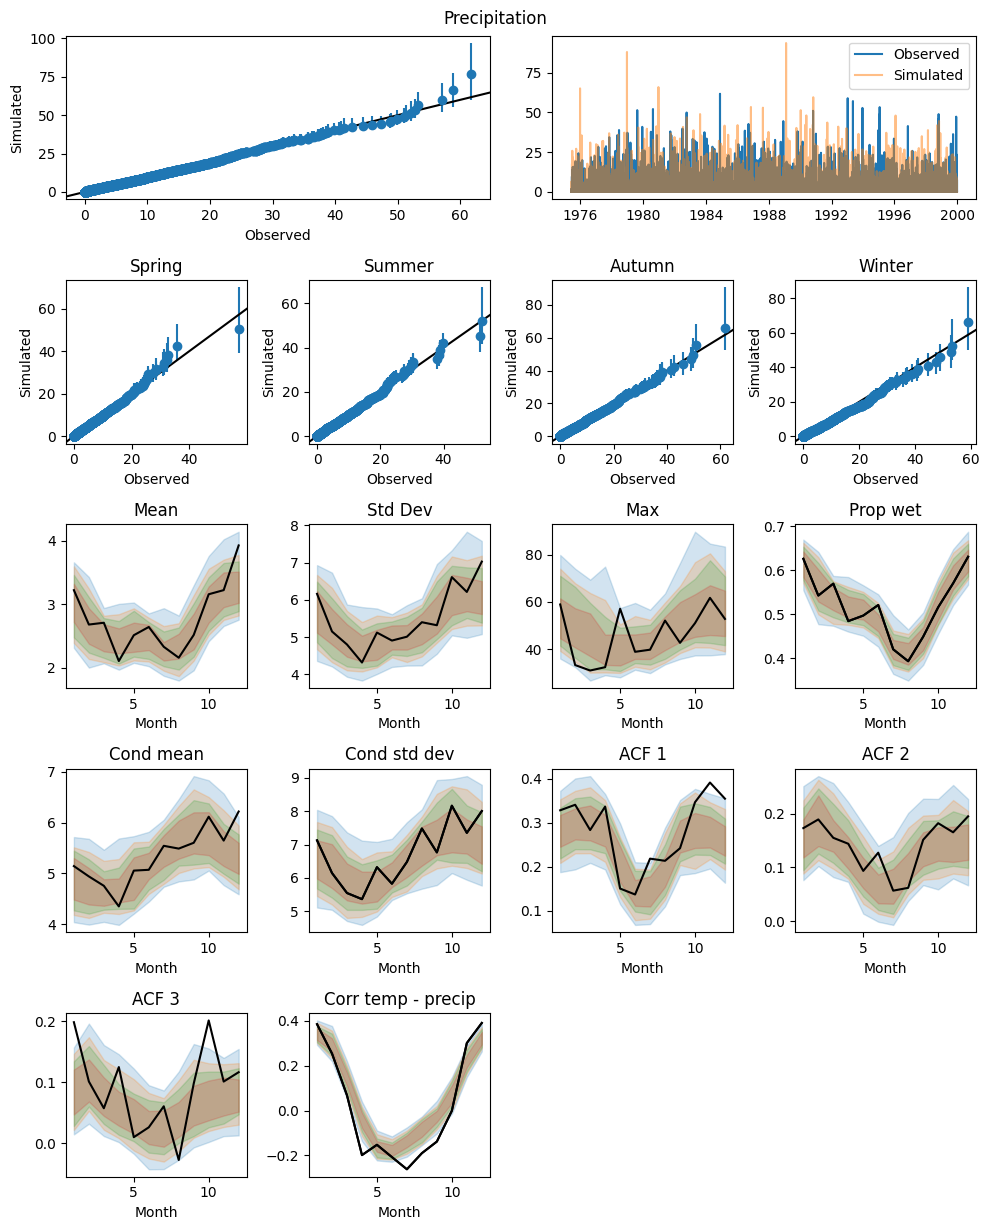

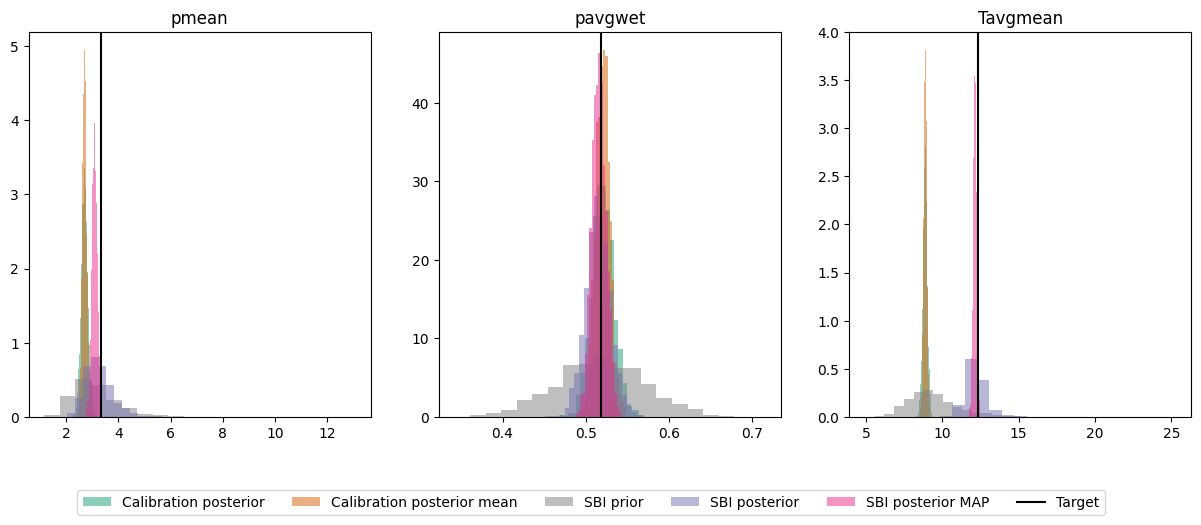

In [8]:
from tqdm import tqdm

for i, basin_data_train in enumerate(basin_data_list):
    try:
        station_id = basin_data_list_ids[i]
        trange_max = (basin_data_train['Tair_max'] - basin_data_train['Tair_min']).max()
        print(f"\n🔹 Fitting GAMLSS model for station {station_id}...")
        wgen = wx.WGEN(basin_data_train, model = WGEN_GAMLSS(), order = 2, Tair_freqs=[1/365.25, 2/365.25], prec_freqs=[1/365.25, 2/365.25], Trange_max_default=trange_max+1.0)

        # Fit model using SVI
        num_iter = 50_000
        prng = random.PRNGKey(1234)
        guide = AutoMultivariateNormal(wgen.step, init_loc_fn=numpyro.infer.init_to_median)
        svi_result = wgen.fit(num_iter, guide, subsample_time=1000, rng=prng)  

        # Get posterior params
        posterior_sampler = Predictive(guide, params=svi_result.params, num_samples=100)
        posterior_params = posterior_sampler(prng)

        # Get predictive
        svi_predictive = Predictive(wgen.simulate, posterior_samples=posterior_params, parallel=True)
        svi_preds = svi_predictive(prng)

        from weathergen.plotting import *
        obs = wgen.obs
        obs["Tmin"] = obs["Tavg"] - obs["Trange"] * obs["Tskew"]
        obs["Tmax"] = obs["Tmin"] + obs["Trange"]

        Tavg_overview(obs, svi_preds, basin_data_train)
        prec_overview(obs, svi_preds, basin_data_train)

        # Run SBI
        num_rounds = 5
        @wxsbi.summarystats("pmean", "pavgwet", "Tavgmean")
        def case_study_1a(prec, Tavg, **kwargs):
            pmean = jnp.mean(prec, axis = -1)
            pavgwet = jnp.mean(prec > 0, axis = -1)
            Tavgmean = jnp.mean(Tavg, axis = -1)
            return jnp.stack([pmean, pavgwet, Tavgmean], axis = -1)
        obs_stats = case_study_1a(**obs).flatten()
        obs_stats_target = obs_stats
        obs_stats_target = obs_stats_target.at[0].mul(1.2)
        obs_stats_target = obs_stats_target.at[2].add(3.5)


        parameter_mask = wgen.get_parameter_mask(["Trange", "Tskew", "precip_occ_"])
        simulator = wxsbi.build_simulator(wgen, case_study_1a, parallel = True)
        cm_prior = wxsbi.get_rescaled_svi_posterior(guide, svi_result, parameter_mask=parameter_mask)
        result = wxsbi.run_sbi(simulator, obs_stats_target, prior = cm_prior, calibration_posterior = guide.get_posterior(svi_result.params), num_samples = 2000, num_rounds = num_rounds, simulation_batch_size = 500, simulations_per_round = 1000)

        try:
            wxsbi.plot_target_densitites_sbi(result)
        except:
            pass
        result.to_file(f"sbi_results/many_stations/{station_id}.pkl")
    except Exception as e:
        print(e)

# Analysis

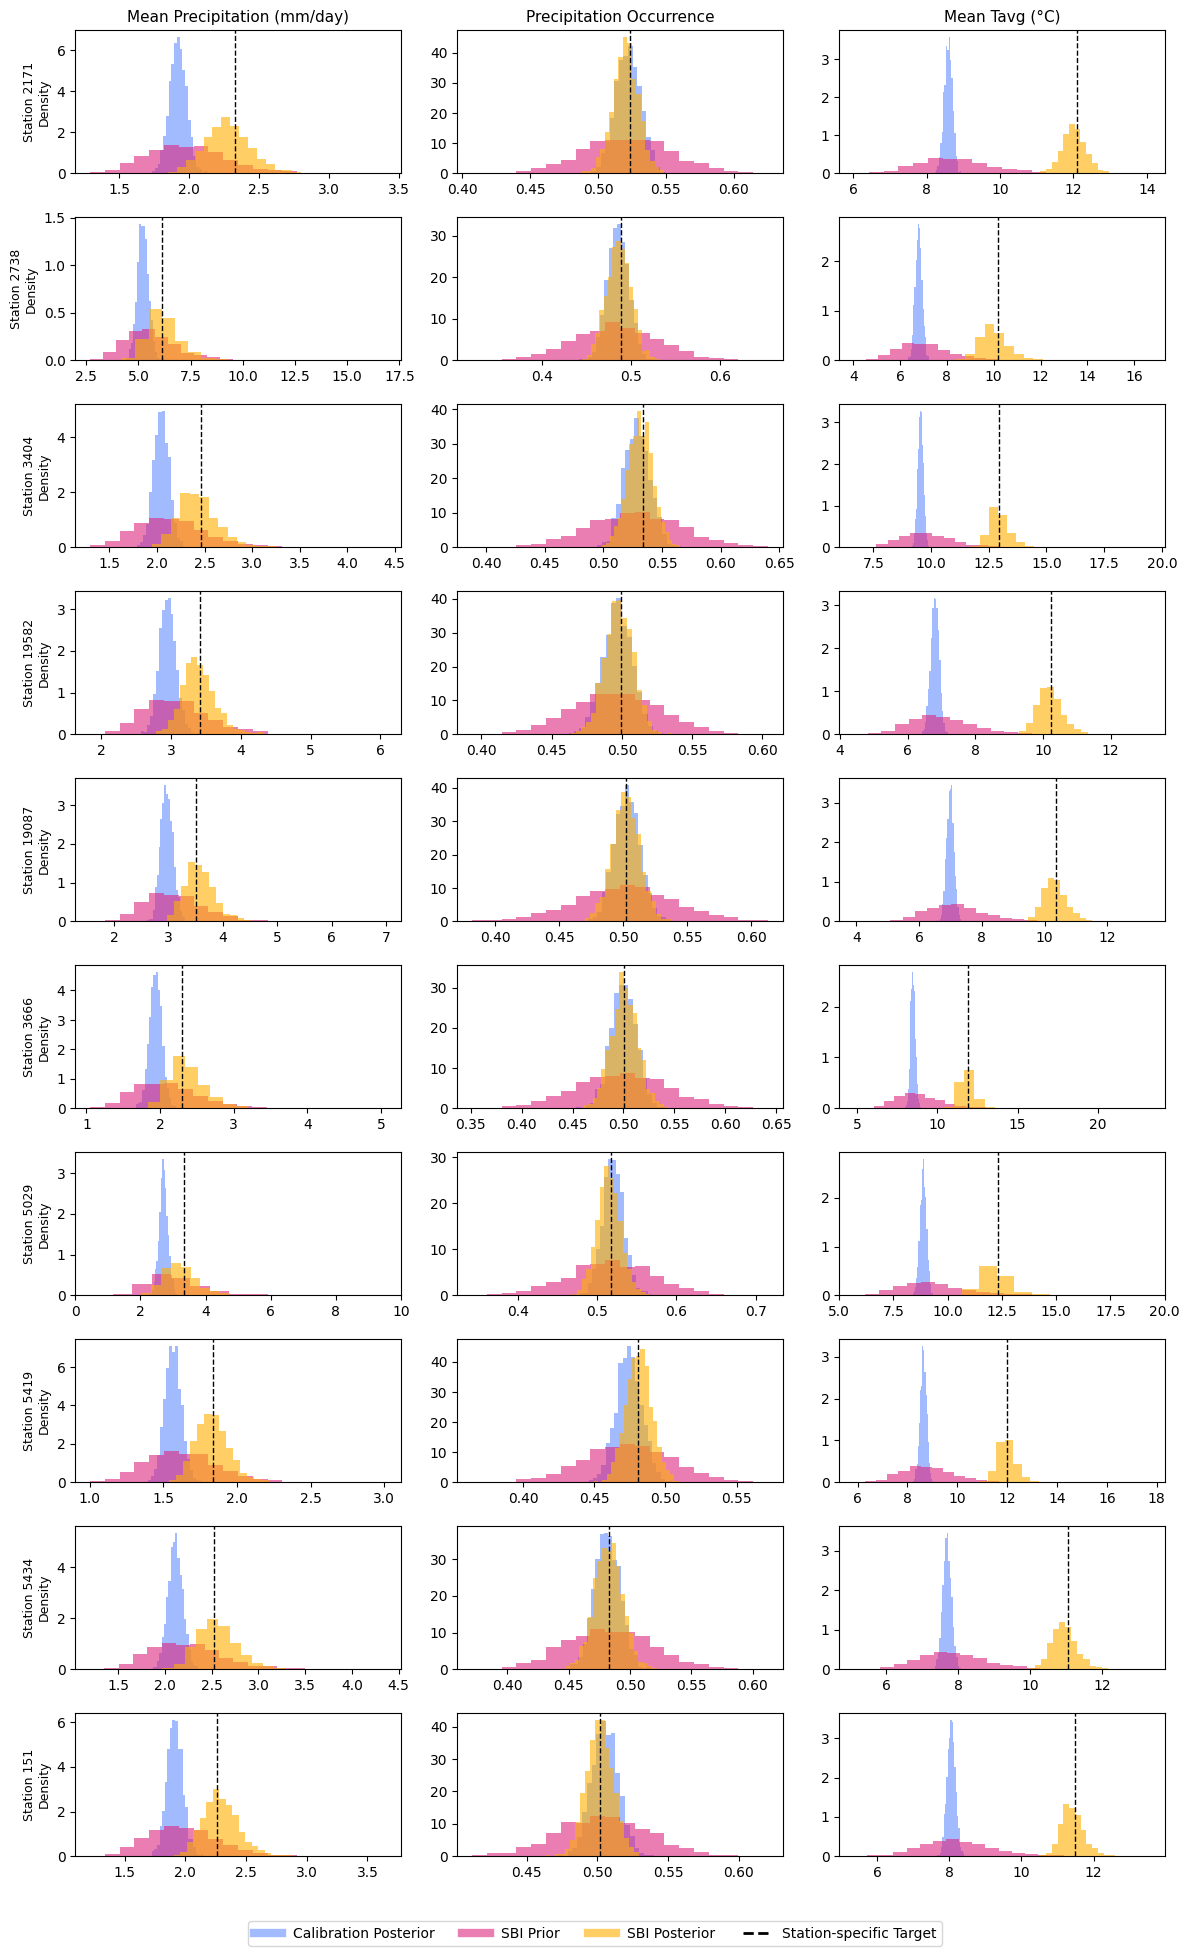

In [9]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import wxsbi

# Color palette (Paul Tol Bright)
colors = {
    "calibration_posterior": "#648FFF",  # blue
    "sbi_prior": "#DC267F",              # magenta
    "sbi_posterior": "#FFB000"           # orange
}

# Station IDs and files
station_ids = [2171, 2738, 3404, 19582, 19087, 3666, 5029, 5419, 5434, 151] 
files = [f"sbi_results/many_stations/{sid}.pkl" for sid in station_ids]

# Load all SBIResults
results = [wxsbi.SBIResults.from_file(f) for f in files]

# Summary statistics
summary_stat_names = ["Mean Precipitation (mm/day)", "Precipitation Occurrence", "Mean Tavg (°C)"]
n_stats = len(summary_stat_names)
n_stations = len(results)

# Create 10x3 grid (stations x summary stats)
fig, axs = plt.subplots(
    n_stations, n_stats,
    figsize=(n_stats*4, n_stations*1.9),
    layout="tight",
    squeeze=False
)

axs[6,2].set_xlim(5,20)
axs[6,0].set_xlim(0,10)

for i, result in enumerate(results):
    for j, stat_name in enumerate(summary_stat_names):
        ax = axs[i, j]

        prior = result.simulations["sbi_prior"][:, j].flatten()
        post = result.simulations["sbi_posterior"][:, j].flatten()
        calib = result.simulations["calibration_posterior"][:, j].flatten()
        target = result.summary_target[j]

        # Plot histograms
        ax.hist(calib, bins=20, density=True, alpha=0.6, color=colors["calibration_posterior"])
        ax.hist(prior, bins=20, density=True, alpha=0.6, color=colors["sbi_prior"])
        ax.hist(post, bins=20, density=True, alpha=0.6, color=colors["sbi_posterior"])
        ax.axvline(target, color="black", linestyle="--", linewidth=1.0)

        # Only show y-axis on first column
        if j == 0:
            ax.set_ylabel(f"Station {station_ids[i]}\nDensity", fontsize=9)
        else:
            ax.set_ylabel("")

        # Remove x-axis labels
        ax.set_xlabel("")

        # Add summary statistic as title for first row only
        if i == 0:
            ax.set_title(stat_name, fontsize=11)

        #ax.grid(alpha=0.2)

# Create a single legend for the figure
handles = [
    plt.Line2D([0], [0], color=colors["calibration_posterior"], lw=6, alpha=0.6),
    plt.Line2D([0], [0], color=colors["sbi_prior"], lw=6, alpha=0.6),
    plt.Line2D([0], [0], color=colors["sbi_posterior"], lw=6, alpha=0.6),
    plt.Line2D([0], [0], color="black", lw=2, linestyle="--")
]
labels = ["Calibration Posterior", "SBI Prior", "SBI Posterior", "Station-specific Target"]

fig.legend(
    handles, labels,
    loc="upper center", bbox_to_anchor=(0.5, -0.01),
    fancybox=True, shadow=False, ncol=4, frameon=True
)

plt.savefig("plots/analysis_v2/sbi_many_stations_grid.png", dpi=300, bbox_inches="tight")
plt.show()